In [66]:
import numpy as np
import pandas as pd
import random
from os.path import join
import os
import pickle
from glob import glob
import json
import sys

sys.path.append('../annotations/')
from color_harmony import extract_harmonies


In [67]:
DATA_DIR = '../data/'
df_scores_vectors = glob(DATA_DIR + 'scores_modifications*')
df_scores = pd.DataFrame()
for df_score in df_scores_vectors:
    df_score_l = pd.read_csv(df_score)
    df_scores = pd.concat([df_scores, df_score_l], axis=0)

df_scores = df_scores.sort_values('Final Score', ascending=False).reset_index()
df_scores.loc[df_scores['Variable'] == 'V1', 'Feature'] = 'V1'
df_scores.loc[df_scores['Variable'] == 'S1', 'Feature'] = 'S1'
df_scores['Method General'] = df_scores['Method'].str.split('_').apply(lambda x: x[0].replace('False', '').replace('True', ''))
df_scores = df_scores.groupby(['Method General', 'Feature']).first()
df_scores = df_scores.reset_index()

modifications_vectors = glob(DATA_DIR + 'modifications*')
df_modifications_vectors = pd.DataFrame()
for df_modification in modifications_vectors:
    df_modification_l = pd.read_csv(df_modification)
    df_modifications_vectors = pd.concat([df_modifications_vectors, df_modification_l], axis=0)
df_modifications_vectors.loc[df_modifications_vectors['Variable'] == 'V1', 'Feature'] = 'V1'
df_modifications_vectors.loc[df_modifications_vectors['Variable'] == 'S1', 'Feature'] = 'S1'

separation_vectors = glob(DATA_DIR + '*_separation_vector*.csv')
df_sep_vecs = pd.DataFrame()
for df_sep_vec in separation_vectors:
    if 'modifications' not in df_sep_vec:
        df_sep_vec_l = pd.read_csv(df_sep_vec)
        df_sep_vecs = pd.concat([df_sep_vecs, df_sep_vec_l], axis=0)
df_sep_vecs.loc[df_sep_vecs['Variable'] == 'V1', 'Feature'] = 'V1'
df_sep_vecs.loc[df_sep_vecs['Variable'] == 'S1', 'Feature'] = 'S1'

df_scores = df_scores.merge(df_sep_vecs, left_on=['Feature','Variable','Method'], right_on=['Feature','Variable','Method'], how='left')
df_scores = df_scores.merge(df_modifications_vectors, left_on=['Feature','Variable','Method'], right_on=['Feature','Variable','Method'], how='left')
df_scores['Separation Vector (np)'] = [np.array([float(x.strip('[] ')) for x in row['Separation Vector'].replace('\n', ' ').split(' ') if x.strip('[] ') != '']) for i, row in df_scores.iterrows()]
print(df_scores[['Feature', 'Variable', 'Method', 'Final Score']].sample(10), df_scores.shape)


/var/folders/s_/h4qqxs0s7mg2fw0j2hmf3jgh0000gn/T/ipykernel_78215/1013914086.py:6: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df_scores = pd.concat([df_scores, df_score_l], axis=0)


       Feature Variable                            Method  Final Score
17979     Blue    Color   ShapleyVec_True_0.25_8_Color_LR        0.637
34188     Cyan    Color   StyleSpaceTrue_20_8_Color_False        0.572
31251     Blue    Color    StyleSpaceTrue_5_8_Color_False        0.458
38244  Magenta    Color  StyleSpaceFalse_10_8_Color_False        0.227
10316      Red    Color    InterfaceGAN_LR_1_8_Color_True        0.879
36380    Green    Color   StyleSpaceTrue_20_8_Color_False        0.512
25394  Magenta    Color   ShapleyVec_True_0.25_8_Color_LR        0.355
38308  Magenta    Color  StyleSpaceFalse_10_8_Color_False        0.227
23964    Green    Color    ShapleyVec_True_0.5_8_Color_LR        0.427
21088     Cyan    Color    ShapleyVec_True_0.5_8_Color_LR        0.434 (41600, 58)


<img src="../data/color_harmonies.jpg" width="300" height="500" style="align-text:center">

Checking which color harmony is obtained by which color modification

In [35]:
harmonies = {}
for method, group in df_scores[df_scores['lambda'] >= 10].groupby('Method General'):
    harmonies[method] = {}
    print('Assessing similarity among vectors computed with:', method)
    for feature, gg in group.groupby('Feature'):
        harmonies[method][feature] = []
        for hues in gg[['H1', 'H2', 'H3', 'H4', 'H5']].values:
            harmonies[method][feature].append(extract_harmonies(hues))
                

Assessing similarity among vectors computed with: InterfaceGAN
Assessing similarity among vectors computed with: ShapleyVec
Assessing similarity among vectors computed with: StyleSpace


in order:
- monochromatic
- analogous
- complementary
- triadic
- split complementary
- double complementary

In [36]:
for method in harmonies.keys():
    for feature in harmonies[method].keys():
        print(method, feature, list(np.round(np.mean(np.array(harmonies[method][feature]), axis=0), 3)))

InterfaceGAN BW [0.525, 0.878, 0.022, 0.0, 0.025, 0.008]
InterfaceGAN Blue [0.12, 0.268, 0.287, 0.003, 0.587, 0.148]
InterfaceGAN Brown [0.307, 0.93, 0.01, 0.0, 0.008, 0.002]
InterfaceGAN Cyan [0.133, 0.29, 0.36, 0.002, 0.485, 0.185]
InterfaceGAN Green [0.117, 0.38, 0.29, 0.003, 0.245, 0.14]
InterfaceGAN Magenta [0.143, 0.402, 0.093, 0.008, 0.143, 0.045]
InterfaceGAN Red [0.26, 0.523, 0.027, 0.0, 0.038, 0.012]
InterfaceGAN S1 [0.212, 0.798, 0.01, 0.0, 0.032, 0.008]
InterfaceGAN V1 [0.187, 0.63, 0.138, 0.002, 0.148, 0.075]
InterfaceGAN Yellow [0.258, 0.842, 0.022, 0.0, 0.02, 0.02]
ShapleyVec BW [0.518, 0.847, 0.022, 0.0, 0.018, 0.015]
ShapleyVec Blue [0.025, 0.137, 0.373, 0.005, 0.612, 0.192]
ShapleyVec Brown [0.048, 0.863, 0.02, 0.0, 0.032, 0.01]
ShapleyVec Cyan [0.055, 0.177, 0.373, 0.0, 0.61, 0.217]
ShapleyVec Green [0.018, 0.177, 0.337, 0.008, 0.325, 0.125]
ShapleyVec Magenta [0.085, 0.28, 0.105, 0.005, 0.117, 0.06]
ShapleyVec Red [0.04, 0.14, 0.087, 0.005, 0.153, 0.052]
ShapleyVec 

In [48]:
def calculate_optimal_lambda(variations):
        L0 = variations[variations['lambda'] == 0]
        SEED2SSIM = {seed:np.round(orig) for orig, seed in zip(L0['SSIM'], L0['seed'])}
        variations['SSIM_change'] = [(SEED2SSIM[seed] - ssim)/ssim for ssim, seed in zip(variations['SSIM'], variations['seed'])]
        optimal_lambda = max([i for i,group in variations.groupby('lambda') if np.mean(np.abs(group['SSIM_change'])) < 0.25])
        return variations, optimal_lambda

Which colors create the most structural change and going into which color

In [57]:
structure = {}
for method, group in df_scores.groupby('Method General'):
    structure[method] = {}
    print('Assessing structureal similarity between images computed with:', method)
    for feature, gg in group.groupby('Feature'):
        structure[method][feature] = {'lambdas':[], 'optimal lambda':None}
        ggg, optimal_lambda = calculate_optimal_lambda(gg)
        structure[method][feature]['lambdas'].append(ggg.groupby('lambda')['SSIM_change'].mean().values)
        structure[method][feature]['optimal lambda'] = optimal_lambda
        print('Optimal lambda for method', method, 'for feature', feature, 'is', optimal_lambda)
                    

Assessing structureal similarity between images computed with: InterfaceGAN
Optimal lambda for method InterfaceGAN for feature BW is 4.0
Optimal lambda for method InterfaceGAN for feature Blue is 9.0
Optimal lambda for method InterfaceGAN for feature Brown is 15.0
Optimal lambda for method InterfaceGAN for feature Cyan is 12.0
Optimal lambda for method InterfaceGAN for feature Green is 15.0
Optimal lambda for method InterfaceGAN for feature Magenta is 6.0
Optimal lambda for method InterfaceGAN for feature Red is 15.0
Optimal lambda for method InterfaceGAN for feature S1 is 9.0
Optimal lambda for method InterfaceGAN for feature V1 is 4.0
Optimal lambda for method InterfaceGAN for feature Yellow is 15.0
Assessing structureal similarity between images computed with: ShapleyVec
Optimal lambda for method ShapleyVec for feature BW is 2.0
Optimal lambda for method ShapleyVec for feature Blue is 8.0
Optimal lambda for method ShapleyVec for feature Brown is 15.0
Optimal lambda for method Shaple

/var/folders/s_/h4qqxs0s7mg2fw0j2hmf3jgh0000gn/T/ipykernel_78215/1718186214.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  variations['SSIM_change'] = [(SEED2SSIM[seed] - ssim)/ssim for ssim, seed in zip(variations['SSIM'], variations['seed'])]
/var/folders/s_/h4qqxs0s7mg2fw0j2hmf3jgh0000gn/T/ipykernel_78215/1718186214.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  variations['SSIM_change'] = [(SEED2SSIM[seed] - ssim)/ssim for ssim, seed in zip(variations['SSIM'], variations['seed'])]


In [58]:
for method in structure.keys():
    for feature in structure[method].keys():
        for lambd in range(1,16):
            print(method, feature, len(structure[method][feature]['lambdas'][0]), structure[method][feature]['lambdas'][0][lambd], lambd)

InterfaceGAN BW 16 0.04121196684777319 1
InterfaceGAN BW 16 0.08621141378706824 2
InterfaceGAN BW 16 0.14226247223758498 3
InterfaceGAN BW 16 0.20109796065979477 4
InterfaceGAN BW 16 0.2851187567165076 5
InterfaceGAN BW 16 0.3775664997324417 6
InterfaceGAN BW 16 0.5720837241964893 7
InterfaceGAN BW 16 0.7802322909414117 8
InterfaceGAN BW 16 0.5559499290781263 9
InterfaceGAN BW 16 0.6946759704912001 10
InterfaceGAN BW 16 1.1580861555369752 11
InterfaceGAN BW 16 3.8516890790827683 12
InterfaceGAN BW 16 nan 13
InterfaceGAN BW 16 nan 14
InterfaceGAN BW 16 nan 15
InterfaceGAN Blue 16 0.018196851597378667 1
InterfaceGAN Blue 16 0.04974661227409599 2
InterfaceGAN Blue 16 0.07179586366386471 3
InterfaceGAN Blue 16 0.09545439337044949 4
InterfaceGAN Blue 16 0.12084044351423015 5
InterfaceGAN Blue 16 0.15074699900617872 6
InterfaceGAN Blue 16 0.17739629610317503 7
InterfaceGAN Blue 16 0.19842698831512012 8
InterfaceGAN Blue 16 0.22003457212295754 9
InterfaceGAN Blue 16 0.24241284240944558 10
Int

In [63]:
structure = {}
for method, group in df_scores.groupby('Method General'):
    structure[method] = {}
    print('Assessing structureal similarity between images computed with:', method)
    for feature, gg in group.groupby('Feature'):
        structure[method][feature] = {}
        gg, optimal_lambda = calculate_optimal_lambda(gg)
        structure[method][feature]['optimal lambda'] = optimal_lambda
        for color, ggg in gg.groupby('Color'):
            structure[method][feature][color] = {'lambdas':[], 'optimal lambda':None}
            structure[method][feature][color]['lambdas'].append(ggg.groupby('lambda')['SSIM_change'].mean().values)
            

Assessing structureal similarity between images computed with: InterfaceGAN
Assessing structureal similarity between images computed with: ShapleyVec
Assessing structureal similarity between images computed with: StyleSpace


/var/folders/s_/h4qqxs0s7mg2fw0j2hmf3jgh0000gn/T/ipykernel_78215/1718186214.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  variations['SSIM_change'] = [(SEED2SSIM[seed] - ssim)/ssim for ssim, seed in zip(variations['SSIM'], variations['seed'])]
/var/folders/s_/h4qqxs0s7mg2fw0j2hmf3jgh0000gn/T/ipykernel_78215/1718186214.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  variations['SSIM_change'] = [(SEED2SSIM[seed] - ssim)/ssim for ssim, seed in zip(variations['SSIM'], variations['seed'])]


In [65]:
for method in structure.keys():
    for feature in structure[method].keys():
        for color in structure[method][feature].keys():
            if color != 'optimal lambda':
                for lambd in range(1,16):
                    try:
                        print(method, feature, color, structure[method][feature][color]['lambdas'][0][lambd], lambd)
                    except:
                        print('')

InterfaceGAN BW BW 0.04718964263464459 1
InterfaceGAN BW BW 0.1008961946646884 2
InterfaceGAN BW BW 0.16532947159264794 3
InterfaceGAN BW BW 0.2322528133060451 4
InterfaceGAN BW BW 0.3171670674509239 5
InterfaceGAN BW BW 0.40963636872309744 6
InterfaceGAN BW BW 0.6200187805413653 7
InterfaceGAN BW BW 0.833354406591342 8
InterfaceGAN BW BW 0.5858192859235651 9
InterfaceGAN BW BW 0.7277213041111704 10
InterfaceGAN BW BW 1.2099676897012954 11
InterfaceGAN BW BW 4.005899388481223 12
InterfaceGAN BW BW nan 13
InterfaceGAN BW BW nan 14
InterfaceGAN BW BW nan 15
InterfaceGAN BW Blue -0.0399619628197225 1
InterfaceGAN BW Blue -0.008159619122379641 2













InterfaceGAN BW Brown 0.033689503766988885 1
InterfaceGAN BW Brown 0.044340424965307115 2
InterfaceGAN BW Brown 0.06906885883815062 3
InterfaceGAN BW Brown 0.08643630440692822 4
InterfaceGAN BW Brown 0.07104052723691738 5
InterfaceGAN BW Brown 0.11610111776283757 6
InterfaceGAN BW Brown 0.10041923966330135 7
InterfaceGAN BW Brown 0.163

color tonalities

In [84]:
df_scores_correct = df_scores[df_scores['Color'] == df_scores['Feature']]
color2tone = {}
for color, group in df_scores_correct[df_scores_correct['lambda']>10].groupby('Feature'):
    color2tone[color] = [(h/360,s/100,v/100) for h,s,v in zip(group['H1'], group['S1'], group['V1'])][:30]
    print(len(color2tone[color]), color)
    

30 BW
30 Blue
30 Brown
30 Cyan
30 Green
30 Magenta
30 Red
30 Yellow


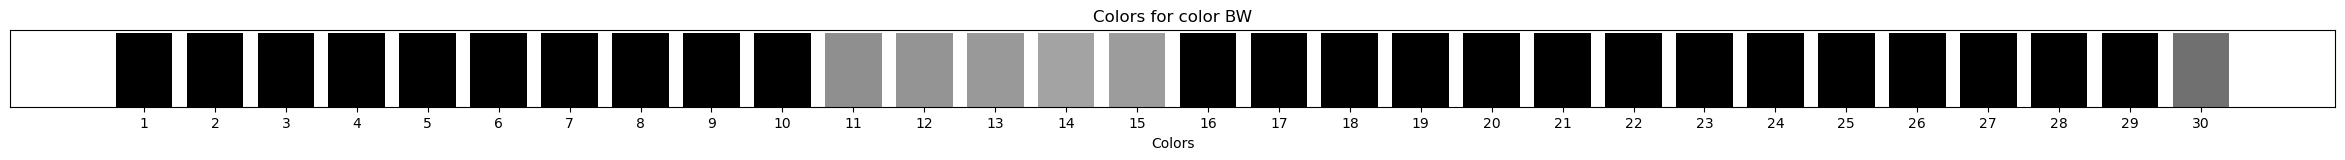

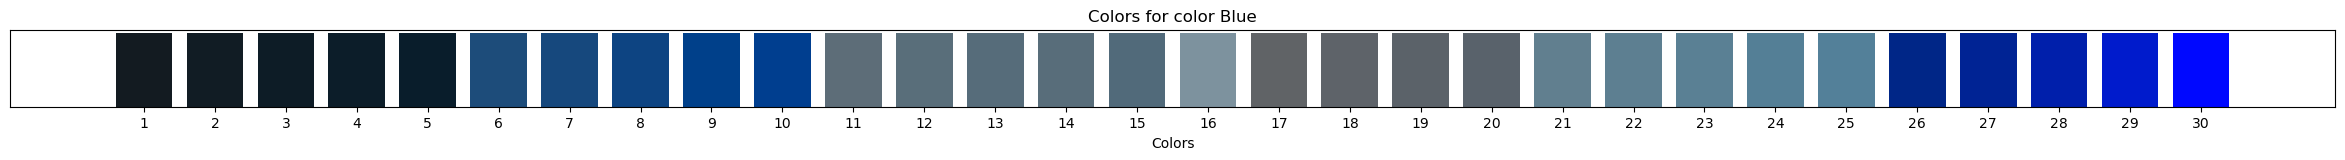

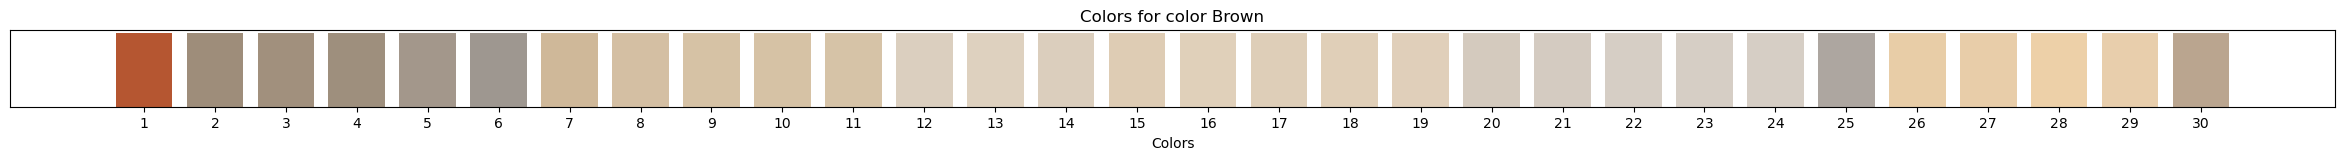

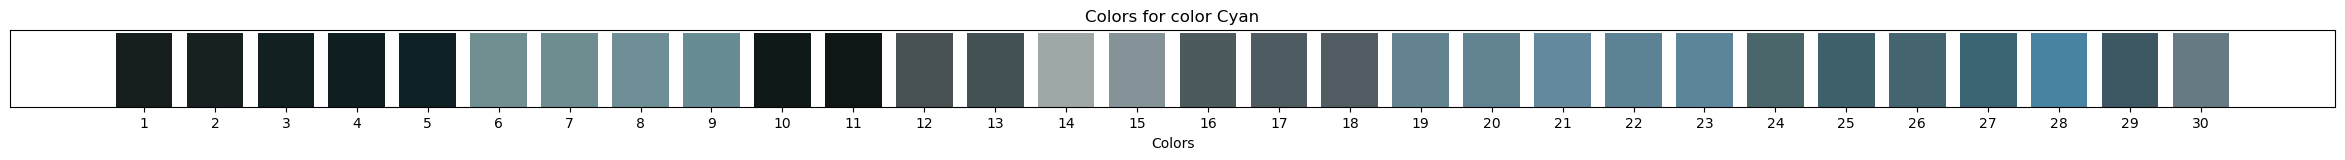

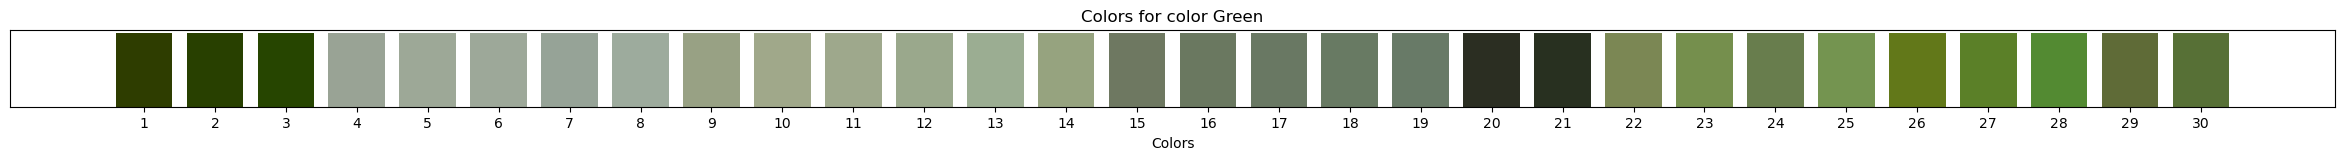

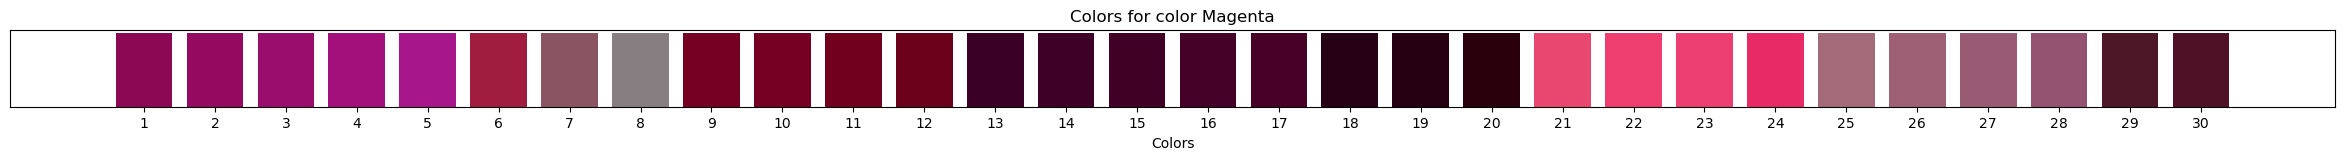

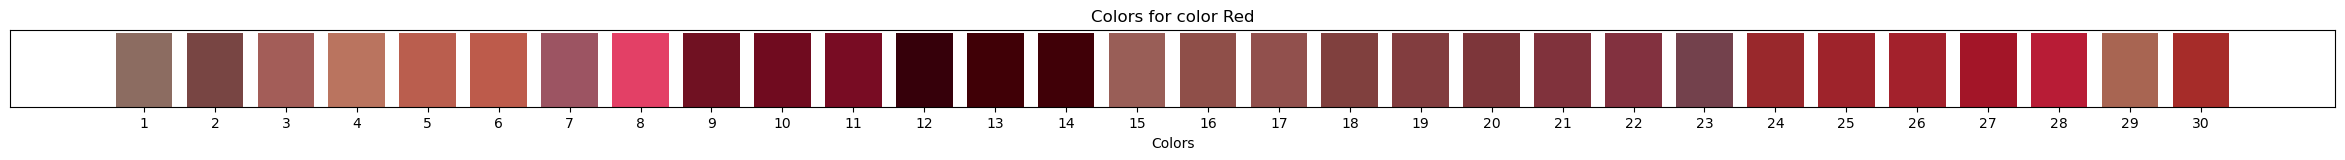

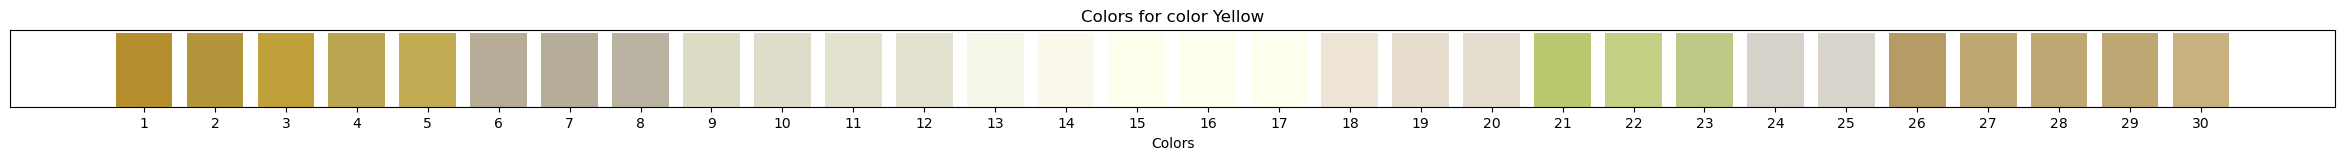

In [85]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt


for color, vals in color2tone.items():
    # Convert HSV to RGB
    rgb_colors = [mcolors.hsv_to_rgb(color) for color in vals]
    # Create a plot with each color
    fig, ax = plt.subplots(figsize=(len(vals), 1))  # Adjust the size as needed

    # Use a bar plot to display each color
    ax.bar(range(len(rgb_colors)), [1]*len(rgb_colors), color=rgb_colors)

    # Remove y-axis and ticks for clarity
    ax.set_yticks([])
    ax.set_xticks(range(len(rgb_colors)))
    ax.set_xticklabels(range(1, len(rgb_colors) + 1))

    # Set x-axis label
    ax.set_xlabel('Colors')

    plt.title(f'Colors for color {color}')
    plt.show()